# Speech Emotion Recognition Through Machine Learning

As human beings speech is amongst the most natural way to express ourselves. We depend so much on it that we recognize its importance when resorting to other communication forms like emails and text messages where we often use emojis to express the emotions associated with the messages. As emotions play a vital role in communication, the detection and analysis of the same is of vital importance in today’s digital world of remote communication. Emotion detection is a challenging task, because emotions are subjective. There is no common consensus on how to measure or categorize them. We define a SER system as a collection of methodologies that process and classify speech signals to detect emotions embedded in them. Such a system can find use in a wide variety of application areas like interactive voice based-assistant or caller-agent conversation analysis. In this study we attempt to detect underlying emotions in recorded speech by analysing the acoustic features of the audio data of recordings.

#Introduction
We are going to build an audio emotion classifier. But why you ask, are we doing this? Well, for a few reasons:


###Because we can
With recent advancements of Deep Learning, better hardware and more open sourcing of data, this enables us to build the capability that we couldn't before. So, why not.

###Accessibility
I've specifically chosen emotion as our target because its one of the more accesible labeled dataset. Don't misunderstand, there are many good quality audio datasets out there, but many are either not relevant (eg. background noises), or locked behind paid wall. Emotions are probably relevant enough since we are dealing with conversations between agent and customer, and there's variety of sources. Also, emotions are general enough (not context dependent), so we can apply to a vast number of different projects

In [46]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import librosa
import librosa.display
import IPython.display as ipd 

# Creating Dataset

### RAVDESS DATASET Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)

RAVDESS is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

Video-only (02)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12) - Female (as the actor ID number is even)
At my early beginings embarking on this journey, I learnt through the hard way that male and female speakers have to be trained seperately or the model will struggle to get a good accuracy. From reading a few blogs and articles, it seems female has a higher pitch that male. So if we don't tag the gender label to the audio file, it won't be able to detect anger or fear if it was a male speaker. It will just get bucketed into neutral

Lets specifically model the 2 speakers seperately. Note that there's a 'calm' emotion and a 'neutral' emotion as seperate. I don't really know the difference but for now, I'll just combined them into the same category.

In [2]:
# with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Dataset/speech-emotion-recognition-ravdess-data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Dataset/speech_data')

In [3]:
# Ravdess dataset file path
RAV = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Dataset/speech_data/'
dir_list = os.listdir(RAV)
dir_list.sort()


emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df1 = pd.DataFrame(emotion)
RAV_df1 = RAV_df1.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df1['source'] = 'RAVDESS'  
RAV_df1 = pd.concat([RAV_df1,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df1.rename(columns={0:'label'},inplace=True)

In [4]:
# Ravdess Dataset path
RAV_df1.head()

,label,source,path
0,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
1,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
2,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
3,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
4,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...


Explore the data
Lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. And how different they are to SAVEE as we go along. Lets start with a fearful track

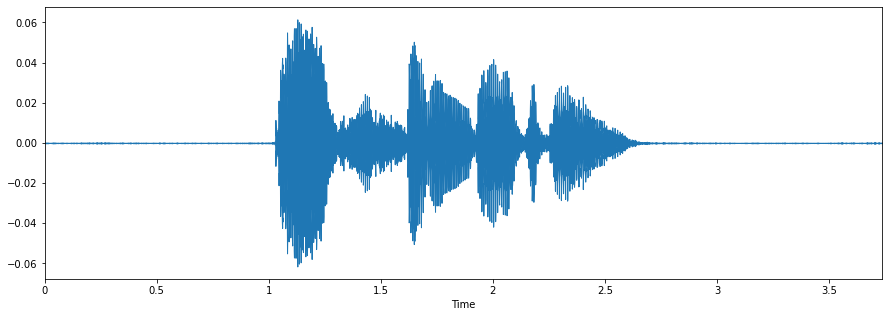

In [5]:
# Pick a fearful track
fname = RAV + 'Actor_17/03-01-02-01-02-01-17.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

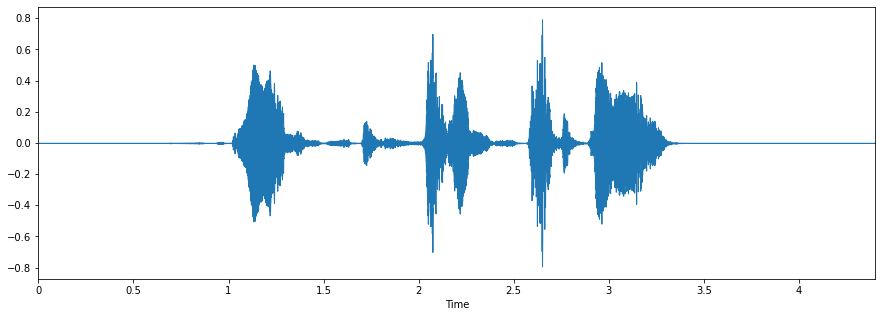

In [6]:
# Pick a angry track
fname = RAV + 'Actor_14/03-01-05-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

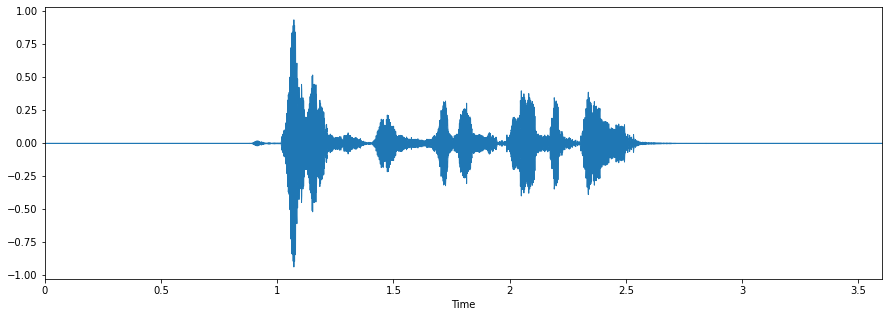

In [7]:
# Pick a angry track for male
fname = RAV + 'Actor_15/03-01-05-02-02-02-15.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

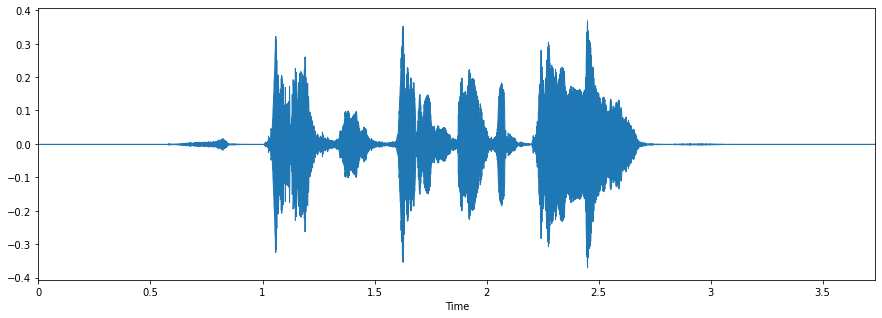

In [8]:
# Pick a happy track
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

Conclusion

...ok, to be fairly honest, I actual felt like that was a fearful tone at the start, up until the end. I had to play it 3 or 4 times to finally be convienced that it is indeed a happy sound. Looking at the wave plot between the 2 files, I notice the only real difference is the amplitute wherein this happy track has a higher amplituted at various points. But, could be coincidence, who knows at this stage.

What I do know is that the audio quality is good and we need females in the dataset. If we don't include females, we'll end up with an AI that is bias towards / aagainst one gender, and its unethical. Unless there's a good reason, I'm not taking it out.

### Get tess Datset from Kaggle

In [9]:
! pip install -q kaggle

In [10]:
from google.colab import files

In [11]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandeepr2111","key":"e00a1c1eba88e2b791e0749c5d8381d4"}'}

In [12]:
! mkdir ~/.kaggle

In [13]:
! cp kaggle.json ~/.kaggle/

In [14]:
! chmod 600 ~/.kaggle/kaggle.json

In [15]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-07-07 19:18:09           9049  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5540  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1999  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2389  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [16]:
! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 98% 418M/428M [00:09<00:00, 39.1MB/s]
100% 428M/428M [00:10<00:00, 44.4MB/s]


In [17]:
! mkdir train

In [18]:
! unzip toronto-emotional-speech-set-tess.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: train/TESS Toronto emotional speech set data/OAF

Final thoughts

Tess and Ravdess dataset are good datasets. Having listen to them and doing some really rough inspections, I feel we can combine both of them. We need to anyway or else we will run into problems with overfitting. One of the issues that I see many other people before me who have made an attempt on an emotion classifier, they tend to stick to just one dataset. And whilst their hold-out set accuracy is high, they don't work well on new unseen dataset.

This is because, the classifier is trained on the same dataset and given the similar circumstances that the dataset was obtained or produced, (eg. audio quality, speaker repetition, duration and sentence uttered). To enable it to do well on new datasets, it needs to be given noise, make it work hard to find the real distinguishing characteristics of the emotion.

Before we end it, final steps are to combine all the meta-data together as one. Remember we saved the paths for all the audio files. So this will be handy when we need to read  data sources in different folder structures.

### TESS

3. TESS dataset
Now on to the TESS dataset, its worth nothing that it's only based on 2 speakers, a young female and an older female. This should hopefully balance out the male dominant speakers that we have on SAVEE.

Its got the same 7 key emotions we're interested in. But what is slightly different about this dataset compared to the previous two above, is that the addition of 'pleasant surprise' emotion. I haven't really checked to see for the RADVESS and SAVEE dataset, if the surpises are unpleasant. But I'm going to work with the assumption for now that its a pleasant surprise. If we find out from post modelling, surpise is highly inaccurate, we can come back and modify our assumption here.

In [19]:
TESS = '/content/train/TESS Toronto emotional speech set data/'
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [20]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['label'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.label.value_counts()

disgust     400
happy       400
sad         400
neutral     400
fear        400
surprise    400
angry       400
Name: label, dtype: int64

Explore the data
400 files for each key emotion. Nice. So lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with.

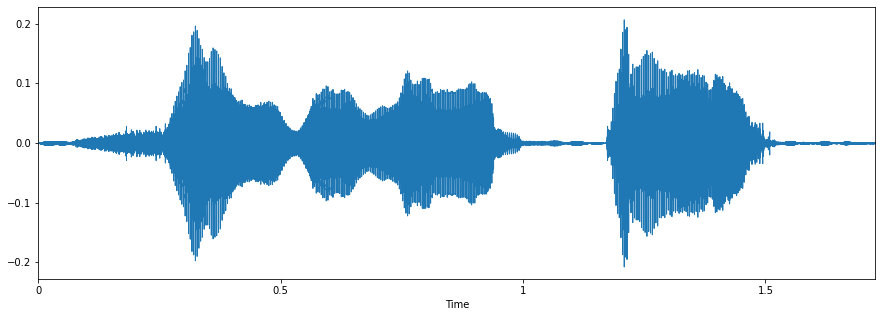

In [21]:
# Pick a fear track
fname = TESS +'OAF_Fear/OAF_back_fear.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

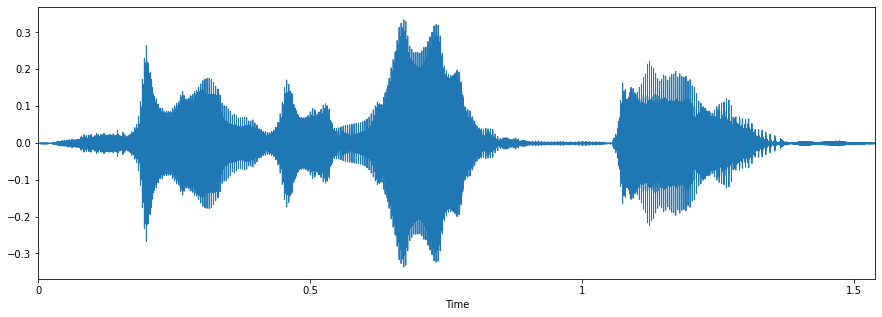

In [22]:
# Pick a angry track
fname = '/content/train/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

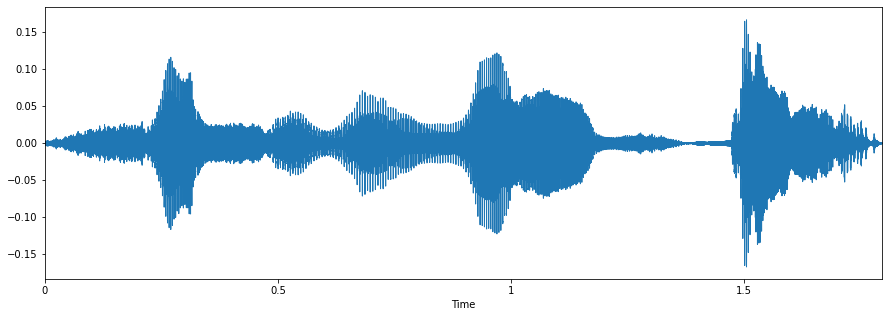

In [23]:
# Pick a happy track
fname = '/content/train/TESS Toronto emotional speech set data/OAF_happy/OAF_bought_happy.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [24]:
TESS_df.shape

(2800, 3)

In [25]:
TESS_df.head()

,label,source,path
0,fear,TESS,/content/train/TESS Toronto emotional speech s...
1,fear,TESS,/content/train/TESS Toronto emotional speech s...
2,fear,TESS,/content/train/TESS Toronto emotional speech s...
3,fear,TESS,/content/train/TESS Toronto emotional speech s...
4,fear,TESS,/content/train/TESS Toronto emotional speech s...


In [26]:
RAV_df1.head()

,label,source,path
0,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
1,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
2,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
3,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
4,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...


In [27]:
df = pd.concat([RAV_df1,TESS_df], axis = 0)
print(df.label.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

neutral     688
disgust     592
happy       592
sad         592
fear        592
surprise    592
angry       592
Name: label, dtype: int64


In [28]:
df.shape

(4240, 3)

# Feature Extraction

## Introduction

Time domain features
These are simpler to extract and understand, like the energy of signal, zero crossing rate, maximum amplitude, minimum energy, etc.
Frequency based features
are obtained by converting the time based signal into the frequency domain. Whilst they are harder to comprehend, it provides extra information that can be really handy such as pitch, rhythms, melody etc. Check this infographic below:

![alt text](https://www.nti-audio.com/portals/0/pic/news/FFT-Time-Frequency-View-540.png)

1. Audio wave
Audio wave is our first feature. This is of course the first most common form of the data, and is the only time domain feature that I am aware off. Lets use this opportunity to plot the two audio files again at their most native format, which is the wave form. To start off, I'm going to plot them in 3 different sampling rates, at 44kHz, 6kHz and 1000kHz and see how they differ, using the female version of the audio (fname = english385.mp3)

Note that I'm only taking the first 5 seconds of audio for illustration purposes

1. MFCC quick intro
MFCC is well known to be a good feature. And there's many ways you can slice and dice this one feature. But what is MFCC? It stands for Mel-frequency cepstral coefficient, and it is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

This post has a good deep dive into the MFCC should you wish to. The most common machine learning application treats the MFCC itself as an 'image' and becomes a feature. The benefit of treating it as an image is that it provides more information, and gives one the ability to draw on transfer learning. This is certainly legit and yields good accuracy. However, research has also shown that statistics relating to MFCCs (or any other time or frequency domain) can carry good amount of information as well. We'll be investigating both of this methods

2. Deepdive
We can select a few examples and visualise the MFCC. lets take 2 different emotions and 2 different genders, and play it just to get a feel for what we are dealing with. Ie. whether the data (audio) quality is good. It gives us an early insight as to how likely our classifier is going to be successful.

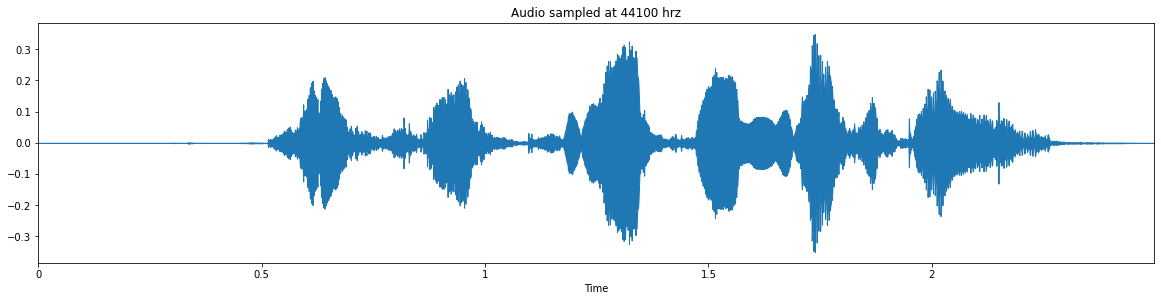

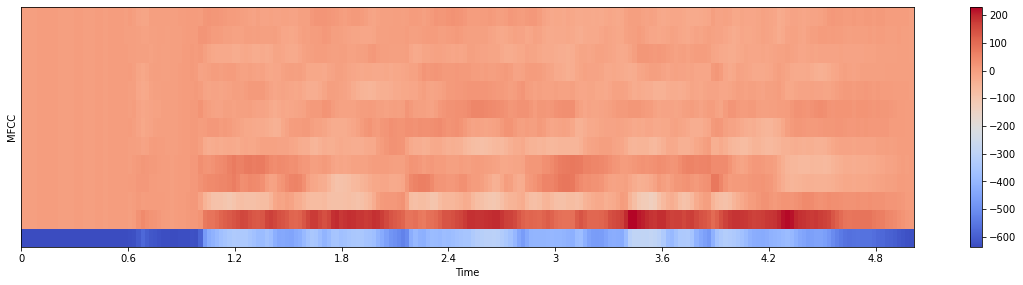

In [29]:
path = RAV+"/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

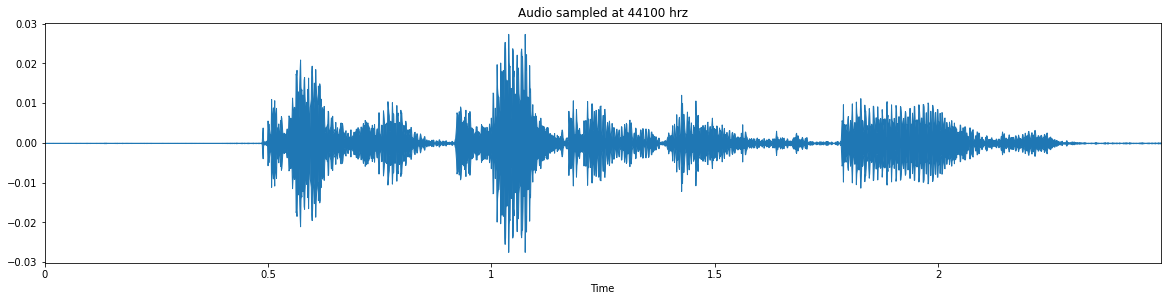

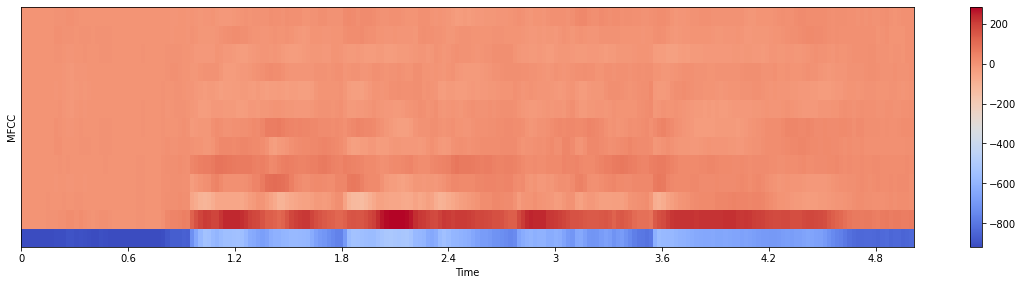

In [30]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = RAV+"/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

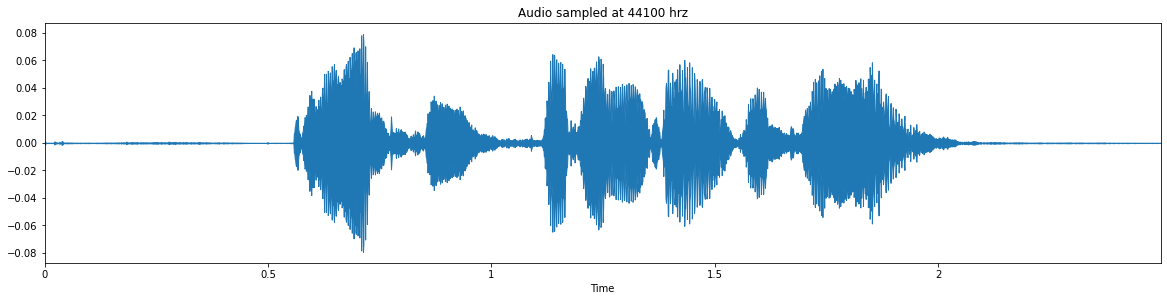

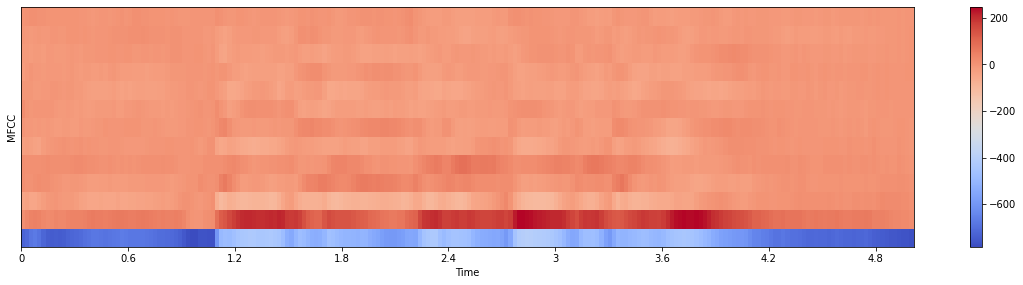

In [31]:
# Source - RAVDESS; Gender - Female; Emotion - Happy 
path = RAV+"/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

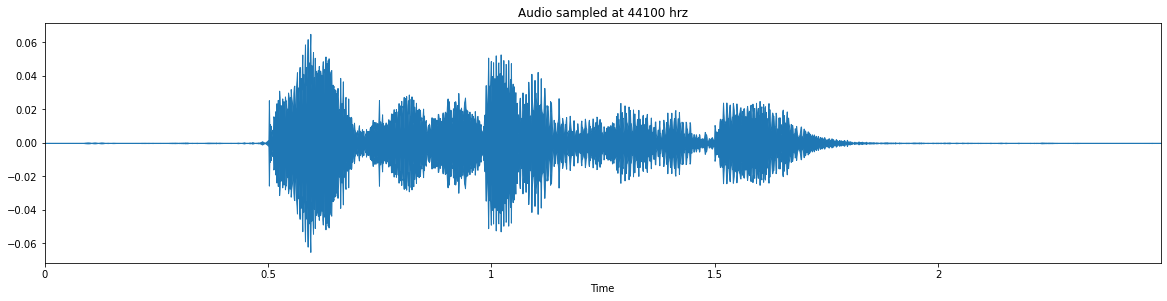

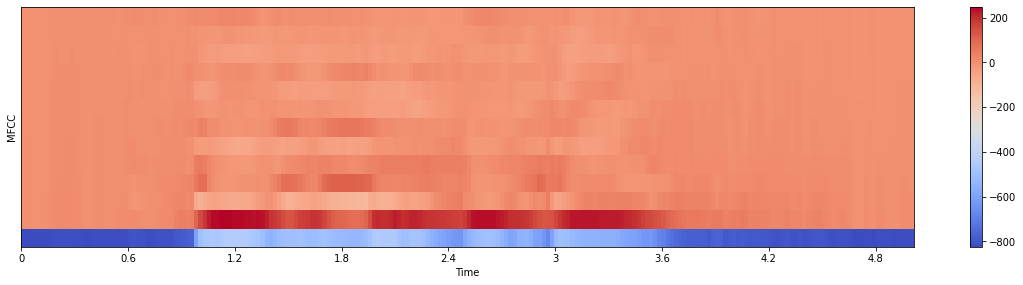

In [32]:
# Source - RAVDESS; Gender - Male; Emotion - Happy 
path = RAV+"/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

### Statistical features
Now we've seen the shape of an MFCC output for each file, and it's a 2D matrix format with MFCC bands on the y-axis and time on the x-axis, representing the MFCC bands over time. To simplify things, what we're going to do is take the mean across each band over time. In other words, row means. But how does it present as a distinctive feature?

So if you look at the above MFCC plot, the first band at the bottom is the most distinctive band over the other bands. Since the time window is a short one, the changes observed overtime does not vary greatly. The key feature is capturing the information contained in the various bands. Lets plot the mean of each of the band and display it as a time series plot to illustrate the point.

We'll compare the Angry female and Angry male for the same sentence uttered.

216
216


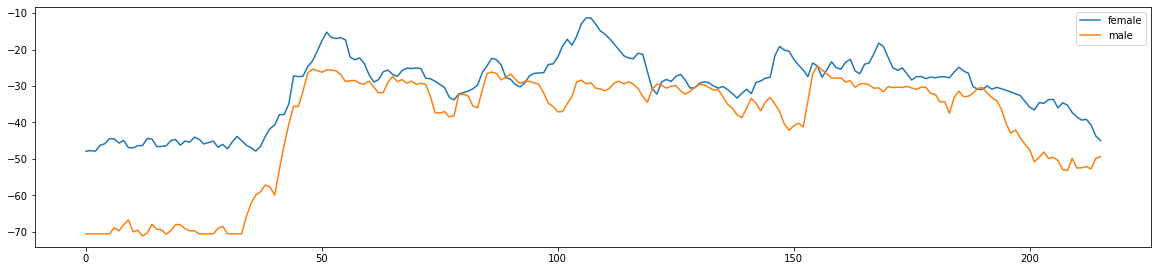

In [33]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = RAV+"/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = RAV+"/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

216
216


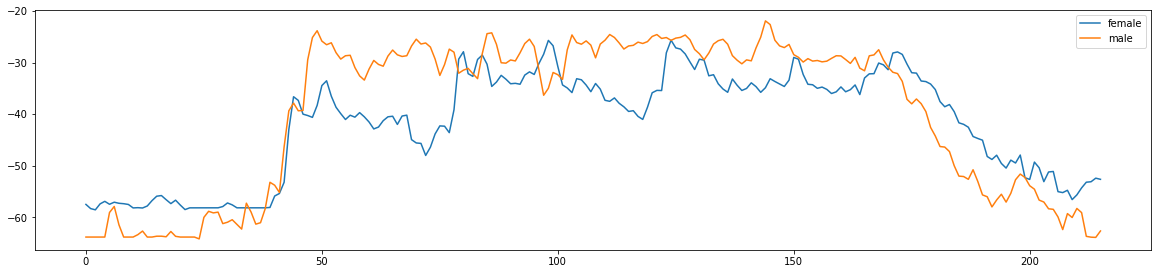

In [34]:
# Source - RAVDESS; Gender - Female; Emotion - Happy 
path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Dataset/speech_data/Actor_02/03-01-03-01-01-01-02.wav'
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Happy 
path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Dataset/speech_data/Actor_01/03-01-03-01-01-01-01.wav'
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

So for the same sentence being uttered, there is a clear distint difference between male and female in that females tends to have a higher pitch. Lets look at a few others. Lets compare a Happy Female and a Happy Male

4. Final thoughts
Using MFCC is a good feature to differentiate the gender and emotions as demonstrated above. Even thou we've ommited alot of good information by just taking the mean, it seems we still capture enough to be able to see some difference. Whether this difference is significant for distinguishing the variou emotions, we'll find out in the next part where we will create a baseline emotion classifier

In [35]:
df_feature = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(df.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=3
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    
    # mean as the feature. Could do min and max etc as well. 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df_feature.loc[counter] = [log_spectrogram]  
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df_feature))
df_feature.head()

4240


,feature
0,"[-76.386314, -76.386314, -76.386314, -76.38631..."
1,"[-75.3977, -75.54153, -75.61404, -74.98727, -7..."
2,"[-75.15178, -75.15178, -75.15178, -75.15178, -..."
3,"[-75.26952, -75.26952, -75.26952, -75.26952, -..."
4,"[-80.148125, -80.148125, -80.148125, -80.14812..."


In [36]:
df_feature = pd.DataFrame(df_feature['feature'].values.tolist())
df_feature.reset_index(drop=True,inplace=True)
df.reset_index(drop=True,inplace=True)

In [37]:
df_feature.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.144318,-75.599464,-75.840088,-75.395958,-75.804054,-75.755386,-75.479980,-74.959122,-73.279915,-72.067093,-67.327347,-66.801376,-70.301811,-72.540604,-72.295853,-73.152763,-73.513618,-74.099297,-72.546440,-70.098099,...,-76.386314,-76.386314,-76.386314,-76.386314,-76.324448,-76.116150,-76.292641,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-75.397697,-75.541527,-75.614037,-74.987267,-75.130745,-75.232170,-75.625504,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.614944,-75.036812,-74.845589,-75.339981,-75.557594,-75.720078,-75.720787,-75.720787,-75.633621,-75.361473,-75.024887,-75.047546,-75.393494,-73.315361,-66.263168,-67.061707,-72.105080,-62.212070,-56.399372,-54.808491,-59.501797,-65.568665,-71.617104,-73.208435,-73.958412,-75.119141,-75.487488,-73.152260,...,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.694069,-75.581436,-75.720787,-75.720787,-75.720787,-75.719337,-75.482018,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151711,-75.128189,-75.151779,-74.960190,-74.073433,-74.170212,-74.587723,-75.136368,-75.142342,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.086922,-74.050262,-73.523094,-74.657112,-74.117683,...,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-74.894608,-74.198570,-74.235916,-74.655830,-74.953911,-74.415131,-74.112686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.235657,-75.153267,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-74.425125,-73.956207,-73.681923,-73.315224,-72.819031,...,-74.757805,-74.666740,-74.871735,-75.261581,-75.081268,-74.629242,-74.421448,-74.667572,-75.173264,-75.269524,-75.269524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-79.680061,-78.959625,-80.092155,-80.148125,-80.148125,-80.148125,-79.918701,-79.418816,-80.113426,-80.148125,-80.148125,-80.096794,-80.148125,-80.100006,-80.043823,-80.103455,-78.585129,-75.074921,-75.151428,-78.666412,...,-78.020905,-78.480354,-79.311745,-78.474884,-77.769402,-78.905533,-79.754036,-80.124481,-78.793854,-78.755516,-80.040794,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.146202,-80.148125,-80.148125,-80.14812

In [ ]:
df_feature.shape

(4240, 216)

In [38]:
df_feature.isnull().sum()

0         0
1         0
2         0
3         0
4         0
       ... 
254    3116
255    3116
256    3177
257    3177
258    3177
Length: 259, dtype: int64

In [39]:
df_feature.fillna(0,inplace=True)

In [40]:
dataset_concated = pd.concat([df_feature,df],axis=1)

In [41]:
dataset_concated.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label,source,path
0,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.144318,-75.599464,-75.840088,-75.395958,-75.804054,-75.755386,-75.479980,-74.959122,-73.279915,-72.067093,-67.327347,-66.801376,-70.301811,-72.540604,-72.295853,-73.152763,-73.513618,-74.099297,-72.546440,-70.098099,...,-76.386314,-76.324448,-76.116150,-76.292641,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,-76.386314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
1,-75.397697,-75.541527,-75.614037,-74.987267,-75.130745,-75.232170,-75.625504,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.614944,-75.036812,-74.845589,-75.339981,-75.557594,-75.720078,-75.720787,-75.720787,-75.633621,-75.361473,-75.024887,-75.047546,-75.393494,-73.315361,-66.263168,-67.061707,-72.105080,-62.212070,-56.399372,-54.808491,-59.501797,-65.568665,-71.617104,-73.208435,-73.958412,-75.119141,-75.487488,-73.152260,...,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.694069,-75.581436,-75.720787,-75.720787,-75.720787,-75.719337,-75.482018,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,-75.720787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
2,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151711,-75.128189,-75.151779,-74.960190,-74.073433,-74.170212,-74.587723,-75.136368,-75.142342,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.086922,-74.050262,-73.523094,-74.657112,-74.117683,...,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-75.151779,-74.894608,-74.198570,-74.235916,-74.655830,-74.953911,-74.415131,-74.112686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
3,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.235657,-75.153267,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-75.269524,-74.425125,-73.956207,-73.681923,-73.315224,-72.819031,...,-75.261581,-75.081268,-74.629242,-74.421448,-74.667572,-75.173264,-75.269524,-75.269524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/AlmaBet...
4,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80.148125,-80

In [42]:
dataset_concated.to_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Dataset/features.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Different kind of Emotioins')

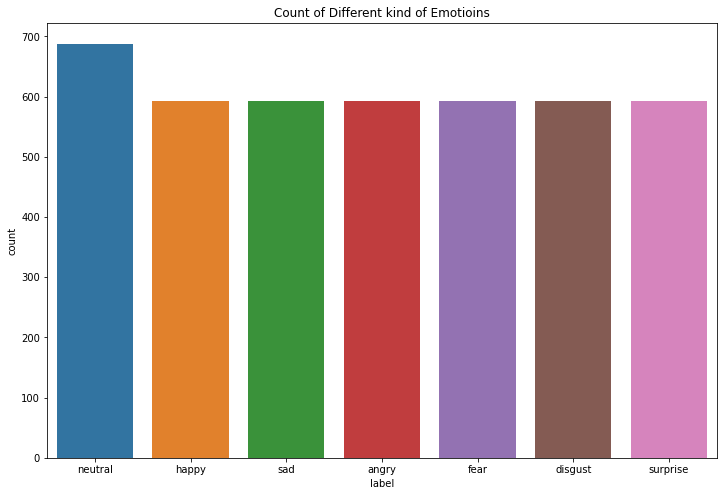

In [49]:
plt.figure(figsize=(12,8))
sns.countplot(dataset_concated.label)
plt.title('Count of Different kind of Emotioins')

In [50]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,History,ReduceLROnPlateau
from tensorflow.keras import regularizers

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [51]:
X_train, X_test, y_train, y_test = train_test_split(dataset_concated.drop(['path','label','source'],axis=1)
                                                    , dataset_concated.label
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
3182,-15.774420,-17.623377,-24.066011,-24.747650,-25.315676,-26.486000,-28.602940,-29.304186,-29.567234,-30.043962,-29.670578,-29.721434,-30.451702,-31.583488,-31.854692,-33.684605,-35.331333,-36.544579,-37.227985,-38.202579,-38.414505,-36.549469,-36.725475,-38.538883,-38.523880,-37.702545,-35.902702,-34.339077,-34.155090,-35.358391,-36.647823,-37.726200,-37.625927,-33.544300,-28.567894,-25.475937,-22.207880,-19.972252,-19.923452,-22.254597,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
386,-63.116741,-63.038017,-63.060230,-63.239132,-63.325813,-63.212551,-63.248585,-63.091888,-63.034256,-63.070282,-62.942394,-63.072628,-63.017319,-63.091125,-63.201767,-63.215782,-63.277546,-63.165913,-63.097538,-63.228909,-63.386208,-63.313602,-63.284939,-63.323647,-63.186409,-63.103844,-63.147038,-63.028927,-63.183216,-63.260094,-63.278397,-63.218140,-63.188473,-63.155975,-63.263680,-63.248188,-63.148083,-62.894577,-62.850780,-62.863472,...,-50.381172,-53.258396,-57.030121,-60.050037,-61.755562,-62.537758,-62.901028,-62.595074,-62.654297,-62.492508,-62.742897,-62.630596,-62.583996,-62.972836,-62.315620,-60.730679,-59.351162,-55.341763,-49.973812,-44.707497,-40.497784,-37.170246,-35.044060,-33.117828,-32.582375,-32.490887,-32.440880,-32.372116,-32.575974,-33.249481,-34.232620,-35.731594,-37.229214,-38.769024,-39.422596,-40.243019,-40.509052,-40.456707,-40.088852,-35.265064
847,-70.236580,-67.930672,-69.739395,-71.674973,-72.627457,-73.636780,-73.746849,-73.340431,-73.219810,-73.273132,-73.377716,-73.806953,-73.971169,-74.117378,-73.563980,-73.397209,-73.714226,-73.313408,-73.350708,-73.481537,-73.297180,-73.781059,-74.136612,-73.946014,-73.073769,-73.346138,-73.029793,-73.246582,-73.873825,-74.086517,-72.947601,-72.141411,-71.602409,-71.915413,-72.455780,-71.428528,-70.080070,-69.256981,-67.951889,-66.124405,...,-70.259781,-70.201500,-68.869453,-68.418106,-69.710045,-70.737030,-70.141891,-70.470787,-70.252007,-72.240120,-72.433784,-71.859093,-72.235092,-71.592461,-71.809731,-72.222000,-71.855125,-71.345474,-71.596519,-71.882233,-71.833939,-72.017166,-71.826981,-71.684166,-71.970512,-72.284554,-72.395004,-72.798820,-72.611153,-72.789062,-73.192497,-73.125076,-72.874611,-72.596741,-72.803650,-73.449905,-73.777184,-73.079582,-73.177765,-73.626961
2836,-33.525360,-34.603474,-37.946342,-38.589214,-39.405361,-40.335800,-40.814495,-40.507412,-40.547474,-40.989449,-41.614967,-42.053444,-42.656654,-43.746326,-45.902016,-47.650478,-48.992237,-49.327316,-49.271736,-47.560635,-45.185890,-42.368889,-39.785751,-39.105007,-38.957256,-40.097301,-40.623543,-40.776211,-42.340149,-43.498581,-45.068943,-46.107613,-47.412678,-49.576580,-51.808743,-53.360332,-54.354099,-54.230469,-54.627842,-54.484943,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1723,-27.395422,-26.661880,-25.062160,-23.757826,-24.880049,-27.539124,-31.040945,-33.929932,-34.683010,-36.003822,-38.034740,-39.451199,-41.124519,-41.768524,-42.375877,-42.946980,-42.675358,-42.646992,-42.650742,-40.515175,-39.040184,-38.472309,-35.817173,-33.670906,-32.894489,-33.146919,-33.173149,-33.489311,-34.501560,-35.296

In [52]:
# Normalization of Features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(3180, 259)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']



Now because we are using a CNN, we need to specify the 3rd dimension, which for us is 1. Its 1 because we're doing a 1D CNN and not a 2D CNN. If we use the MFCC data in its entirity, we could feed that through as the input data, thus making the network a 2D CNN.

In [54]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(3180, 259, 1)

### Modelling
The architecture of the model below is based on a few sources that I've seen before such as Kaggle and Stackoverflow. performed hypermater tuning and trained several models before building this model. before hypermater tuning and with other models accuracy was around 60% to 65%. After training several models and hypermater tuning i got an accuracy clsoe to 81%

In [93]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.0002, rho=0.9, epsilon=1e-07)

In [94]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 259, 128)          768       
_________________________________________________________________
activation_10 (Activation)   (None, 259, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 259, 128)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 64, 256)           164096    
_________________________________________________________________
activation_11 (Activation)   (None, 64, 256)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 256)          

In [95]:
from keras.utils.vis_utils import plot_model

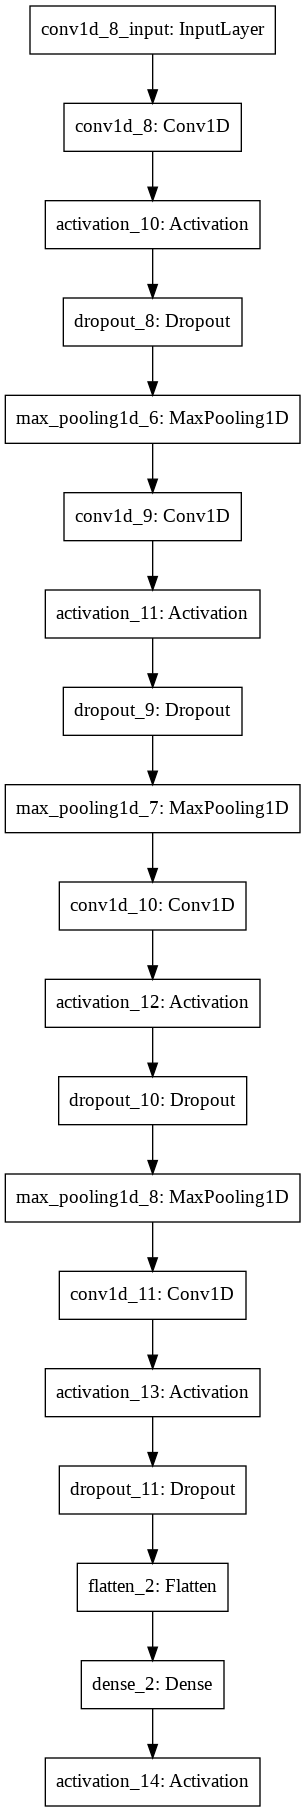

In [96]:
plot_model(model)

In [97]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data=(X_test, y_test))

Epoch 1/300
50/50 [==============================] - 4s 32ms/step - loss: 1.7108 - accuracy: 0.3017 - val_loss: 1.7038 - val_accuracy: 0.4038
Epoch 2/300
50/50 [==============================] - 1s 18ms/step - loss: 1.4109 - accuracy: 0.4357 - val_loss: 1.6084 - val_accuracy: 0.5038
Epoch 3/300
50/50 [==============================] - 1s 17ms/step - loss: 1.3458 - accuracy: 0.4562 - val_loss: 1.5621 - val_accuracy: 0.5519
Epoch 4/300
50/50 [==============================] - 1s 17ms/step - loss: 1.2684 - accuracy: 0.5111 - val_loss: 1.5084 - val_accuracy: 0.5547
Epoch 5/300
50/50 [==============================] - 1s 17ms/step - loss: 1.1822 - accuracy: 0.5456 - val_loss: 1.4652 - val_accuracy: 0.5830
Epoch 6/300
50/50 [==============================] - 1s 16ms/step - loss: 1.1663 - accuracy: 0.5462 - val_loss: 1.4442 - val_accuracy: 0.5858
Epoch 7/300
50/50 [==============================] - 1s 18ms/step - loss: 1.1386 - accuracy: 0.5564 - val_loss: 1.4197 - val_accuracy: 0.5585
Epoch 

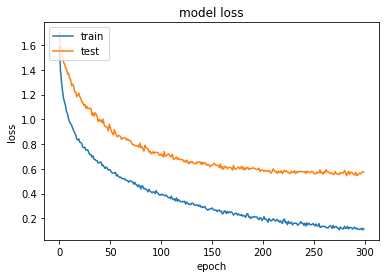

In [98]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

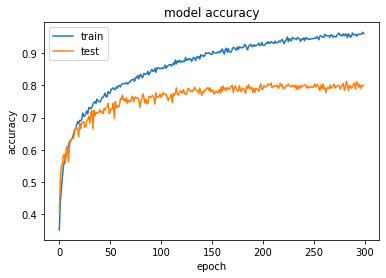

In [99]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [100]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone/'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open(save_dir+"model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone/Emotion_Model.h5 


In [101]:
# loading json and model architecture 
json_file = open('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 80.00%


In [102]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

67/67 [==============================] - 1s 3ms/step


array([0, 5, 3, ..., 0, 4, 5])

In [103]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[150:180]

,actualvalues,predictedvalues
150,happy,happy
151,surprise,surprise
152,happy,happy
153,sad,neutral
154,fear,fear
155,sad,neutral
156,surprise,surprise
157,neutral,neutral
158,angry,angry
159,happy,fear


In [104]:
finaldf.head(10)

,actualvalues,predictedvalues
0,angry,angry
1,surprise,sad
2,happy,happy
3,disgust,disgust
4,sad,sad
5,surprise,surprise
6,happy,happy
7,happy,fear
8,surprise,angry
9,neutral,neutral


In [105]:
from sklearn.metrics import classification_report
report = classification_report(finaldf.actualvalues, finaldf.predictedvalues)
print(report)

              precision    recall  f1-score   support

       angry       0.80      0.79      0.79       138
     disgust       0.85      0.86      0.85       154
        fear       0.72      0.86      0.78       153
       happy       0.81      0.76      0.79       154
     neutral       0.79      0.92      0.85       168
         sad       0.76      0.73      0.75       145
    surprise       0.92      0.66      0.77       148

    accuracy                           0.80      1060
   macro avg       0.81      0.80      0.80      1060
weighted avg       0.81      0.80      0.80      1060



In [106]:
labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

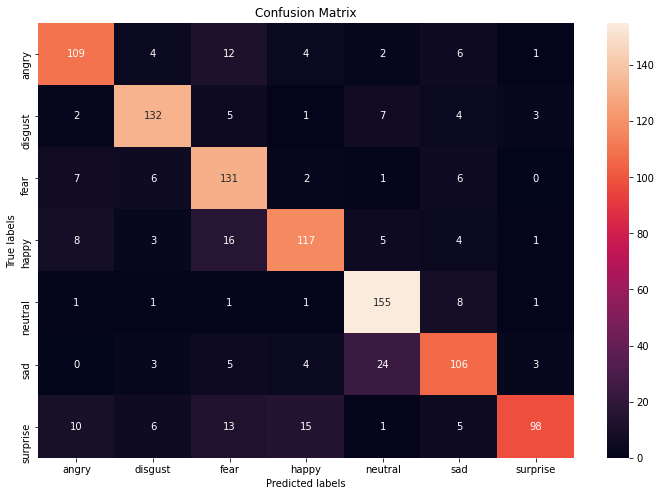

<Figure size 864x576 with 0 Axes>

In [107]:
f, ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap(confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
plt.figure(figsize=(12,8))
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['angry','disgust','fear','happy','neutral','sad','surprise']); ax.yaxis.set_ticklabels(['angry','disgust','fear','happy','neutral','sad','surprise']);

In [108]:
confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)

array([[109,   4,  12,   4,   2,   6,   1],
       [  2, 132,   5,   1,   7,   4,   3],
       [  7,   6, 131,   2,   1,   6,   0],
       [  8,   3,  16, 117,   5,   4,   1],
       [  1,   1,   1,   1, 155,   8,   1],
       [  0,   3,   5,   4,  24, 106,   3],
       [ 10,   6,  13,  15,   1,   5,  98]])

References:

1. https://www.kaggle.com/ejlok1/cremad/code
2. https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3
3. https://www.analyticsinsight.net/speech-emotion-recognition-ser-through-machine-learning/

In [109]:
test_angry = pd.DataFrame(columns=['feature'])
path_angry = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Deep Learning/angry.mp3'
# loop feature extraction over the entire dataset
counter=0
X, sample_rate = librosa.load(path, res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
test_angry.loc[counter] = [mfccs]
counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(test_angry))
test_angry.head()

1


,feature
0,"[-28.054792, -26.714552, -26.82764, -28.02429,..."


In [110]:
path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Deep Learning/angry.wav'

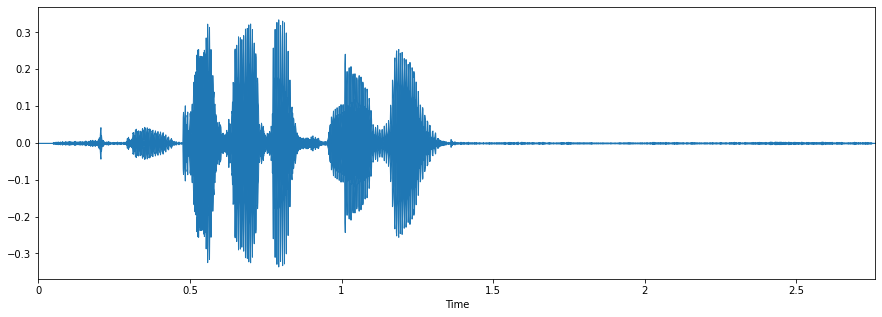

In [111]:
# Pick a angry track
fname = path
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

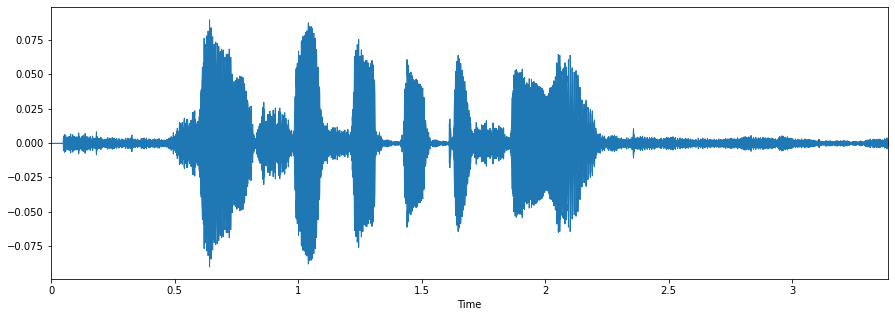

In [112]:
path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Deep Learning/happy.wav'
# Pick a happy track
fname = path
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

# Predictions

In [113]:
test_angry = pd.DataFrame(columns=['feature'])
path_angry = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Deep Learning/angry.wav'
# loop feature extraction over the entire dataset
counter=0
X, sample_rate = librosa.load(path_angry, res_type='kaiser_fast'
                                  ,duration=3
                                  ,sr=44100
                                  ,offset=0.5
                                 )
spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    
db_spec = librosa.power_to_db(spectrogram)
log_spectrogram = np.mean(db_spec, axis = 0)
test_angry.loc[counter] = [log_spectrogram]
counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(test_angry))
test_angry.head()

test_angry = pd.DataFrame(test_angry['feature'].values.tolist())
test_angry.reset_index(drop=True,inplace=True)

test_angry.dropna(axis=0,inplace=True)


test_angry = np.array(test_angry)
test_angry_new = np.append(test_angry,np.zeros(259-test_angry.shape[1],))
test_angry_new = test_angry_new.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(test_angry_new)
test_angry = scaler.transform(test_angry_new)
test_angry_new = np.expand_dims(test_angry_new, axis=1)
test_angry_new = np.expand_dims(test_angry_new, axis=0)

# loading json and model architecture 
json_file = open('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone/Emotion_Model.h5")
print("Loaded model from disk")

#predicting
preds = loaded_model.predict(test_angry_new, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds
labels_dict ={1:'angry',2:'disgust',3:'fear',4:'happy',5:'neutral',6:'sad',7:'surprise'}
print(labels_dict[int(preds)])

1
Loaded model from disk
1/1 [==============================] - 0s 463ms/step
angry


In [114]:
test_angry = pd.DataFrame(columns=['feature'])
path_angry = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Deep Learning/happy.wav'
# loop feature extraction over the entire dataset
counter=0
X, sample_rate = librosa.load(path_angry, res_type='kaiser_fast'
                                  ,duration=3
                                  ,sr=44100
                                  ,offset=0.5
                                 )
spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    
db_spec = librosa.power_to_db(spectrogram)
log_spectrogram = np.mean(db_spec, axis = 0)
test_angry.loc[counter] = [log_spectrogram]
counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(test_angry))
test_angry.head()

test_angry = pd.DataFrame(test_angry['feature'].values.tolist())
test_angry.reset_index(drop=True,inplace=True)

test_angry.dropna(axis=0,inplace=True)


test_angry = np.array(test_angry)
test_angry_new = np.append(test_angry,np.zeros(259-test_angry.shape[1],))
test_angry_new = test_angry_new.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(test_angry_new)
test_angry = scaler.transform(test_angry_new)
test_angry_new = np.expand_dims(test_angry_new, axis=1)
test_angry_new = np.expand_dims(test_angry_new, axis=0)

# loading json and model architecture 
json_file = open('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone/Emotion_Model.h5")
print("Loaded model from disk")

#predicting
preds = loaded_model.predict(test_angry_new, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds
labels_dict ={1:'angry',2:'disgust',3:'fear',4:'happy',5:'neutral',6:'sad',7:'surprise'}
print(labels_dict[int(preds)])

1
Loaded model from disk
1/1 [==============================] - 0s 493ms/step
neutral


# Conclusion

Successfully Built the model for predicting Emotion of people by their voice samples with an accuracy of 80%.

* When model is trained we can see that the model is overfitting as the training accuracy is around 95% while test accuracy is 80%.
* We can overcome Overfitting of the model by adding more audio samples even i tried by adding more samples by including `SAVEE` and `CREMA-D` dataset but the model was not performing well hence i needed to delete those dataset. While we can obtain the data and get more test accuracy.
* Finally tested the model with my own audio samples and the model performed pretty well.  